## Testing Linear Regression on players that survive 4 years, i.e., getting paid on the 4th year

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import power_transform
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from ScrapeProcFunc import *

import warnings
warnings.simplefilter('ignore')

In [3]:
# Import dataset
df = pd.read_csv('./data/Allplayers.csv')

In [4]:
df.sample()

,Unnamed: 0,draftRnd,ht_inch,Wt,dash,yr1,yr2,yr3,yr4,pos_QB,pos_RB,pos_WR,draftStat_No,draftStat_Yes,Salary_log1p
42,42,3,76,231,4.76,191.0,313.9,140.9,60.1,1,0,0,0,1,14.255786


In [5]:
# Select columns to use or NOT use
Xorig = df.drop(['pos_QB','draftStat_No', 'Salary_log1p'],axis=1)
yorig = df['Salary_log1p']

print(Xorig.shape)
Xorig.sample()

(356, 12)


,Unnamed: 0,draftRnd,ht_inch,Wt,dash,yr1,yr2,yr3,yr4,pos_RB,pos_WR,draftStat_Yes
97,20,1,72,223,4.45,0.0,190.8,154.7,135.0,1,0,1


___


### Start Splits: Train, Val, Test

In [6]:
# Hold out 20% of the data for final testing: TRAIN and TEST
Xt, X_test, yt, y_test = train_test_split(Xorig, yorig, test_size=.2, random_state=10)

# Split TRAIN and VALIDATION 
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(Xt, yt, test_size=.25, random_state=3)

In [7]:
print('size of all observations: ', Xorig.shape)
print('size of training set    : ', X_train_t.shape)
print('size of validation set  : ', X_val_t.shape)
print('size of testing set     : ', X_test.shape)

size of all observations:  (356, 12)
size of training set    :  (213, 12)
size of validation set  :  (71, 12)
size of testing set     :  (72, 12)


### Simple LR with 1-fold (validation)


In [8]:
# Simple linear regression
lr = LinearRegression()
lr.fit(X_train_t, y_train_t)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [9]:
print('intercept:', lr.intercept_)
temp = pd.DataFrame(list(zip(X_train_t.columns, lr.coef_)), columns = ['features','coeff'])
temp.sort_values(by='coeff', ascending=False)

intercept: 12.15870437443261


,features,coeff
11,draftStat_Yes,0.133426
2,ht_inch,0.032592
0,Unnamed: 0,0.001724
6,yr2,0.001699
8,yr4,0.001332
7,yr3,0.001258
5,yr1,-0.000039
3,Wt,-0.001161
1,draftRnd,-0.010324
9,pos_RB,-0.130014


In [10]:
# Predict validation set
y_train_pred = lr.predict(X_train_t)
y_val_pred = lr.predict(X_val_t)

mse_train = mean_squared_error(y_train_t, y_train_pred)
mse_val = mean_squared_error(y_val_t, y_val_pred)

print('r2 of train set  :', lr.score(X_train_t, y_train_t))
print('rmse of train set: %s' % np.sqrt(mse_train) )
print()
print('r2 of val set  : ', lr.score(X_val_t, y_val_t))
print('rmse of val set: %s' % np.sqrt(mse_val) )

r2 of train set  : 0.36993911688354064
rmse of train set: 0.6009403741678817

r2 of val set  :  0.325628950858892
rmse of val set: 0.5607167910806471


### Plot Learning Curves, to see if our model performs ok under 356 observations 

In [11]:
# Hold out 20% of the data for final testing: TRAIN and TEST
Xt, X_test, yt, y_test = train_test_split(Xorig, yorig, test_size=.2, random_state=10)

# SPLIT Train_Train and Train_Val
X_train_t, X_val_t, y_train_t, y_val_t =  train_test_split(Xt, yt, test_size=.25, random_state=3)


<Figure size 432x288 with 0 Axes>

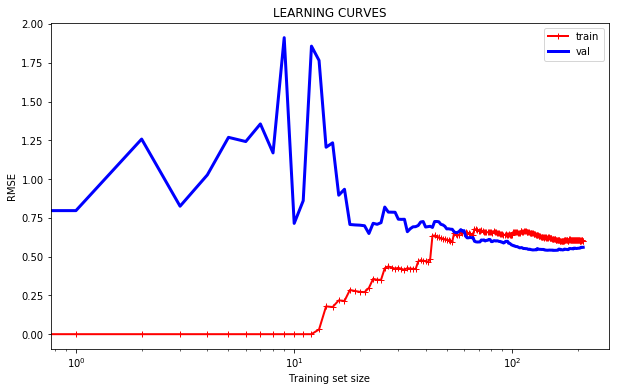

In [12]:
# Checking Learning Curves
fig = plt.figure()
plot_learning_curves(lr, X_train_t, X_val_t, y_train_t, y_val_t)
plt.xscale('log')
plt.savefig('./learningCurves_log.png')

<Figure size 432x288 with 0 Axes>

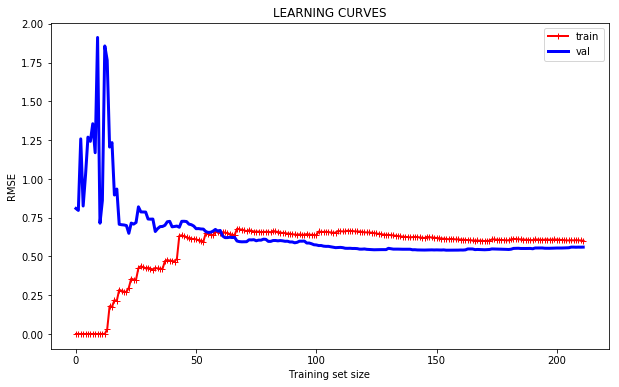

In [13]:
# Checking Learning Curves
fig = plt.figure(figsize=(6,4))
plot_learning_curves(lr, X_train_t, X_val_t, y_train_t, y_val_t)
plt.savefig('./learningCurves.png')

---

### Simple LR with 10-fold CV 

In [14]:
# Select columns to use or NOT use
Xorig = df.drop(['pos_QB','draftStat_No', 'Salary_log1p'],axis=1)
yorig = df['Salary_log1p']
print(Xorig.shape)
Xorig.sample()

(356, 12)


,Unnamed: 0,draftRnd,ht_inch,Wt,dash,yr1,yr2,yr3,yr4,pos_RB,pos_WR,draftStat_Yes
202,17,1,75,210,4.38,37.9,125.6,210.2,2.7,0,1,1


In [15]:
# Hold out 20% of the data for final testing: TRAIN and TEST
X_train, X_test, y_train, y_test = train_test_split(Xorig, yorig, test_size=.2, random_state=10)


In [16]:
print('size of all observations: ', Xorig.shape)
print('size of training set    : ', X_train.shape)
print('size of testing set     : ', X_test.shape)

size of all observations:  (356, 12)
size of training set    :  (284, 12)
size of testing set     :  (72, 12)


In [17]:
# CV score
cv_score = cross_val_score(lr, X_train, y_train, # estimator, features, target
                cv=10, # number of folds 
                scoring='r2') # scoring metric
cv_score.mean()

0.16306071849226975

In [18]:
# Try kfold and CV

kf = KFold(n_splits=10, shuffle=True, random_state = 71)
cv_score_r2 = cross_val_score(lr, X_train, y_train, cv=kf, scoring='r2')
cv_score_mse = cross_val_score(lr, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

print('r2   : ', cv_score_r2.mean())
print('rmse : ', np.sqrt(-cv_score_mse).mean())
    

r2   :  0.29432138110207734
rmse :  0.6091510957180686


---

### Plotting residuals in the simple LR model
- Check for odd patterns in the residuals

In [19]:
# Simple Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

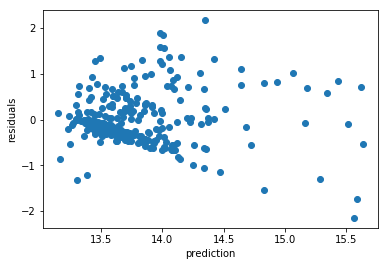

In [20]:
# Residuals of the training data
y_train_pred = lr.predict(X_train)
residuals = y_train - y_train_pred

fig = plt.figure()
plt.plot(y_train_pred, residuals, 'o')
plt.ylabel('residuals')
plt.xlabel('prediction')
fig.savefig('./residuals_train_model.png')

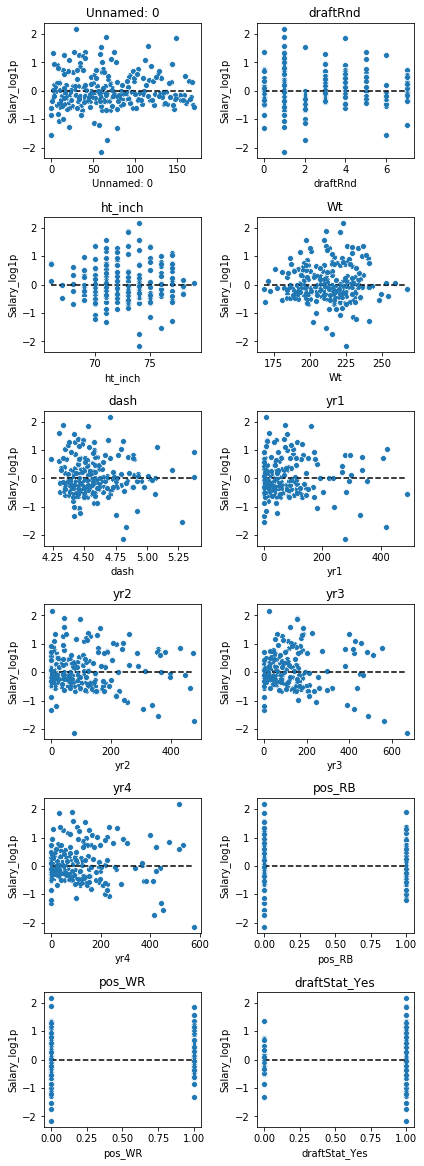

In [21]:
# Plot residuals vs features

labels = list(X_train.columns) 
# Residuals
fig =plt.figure(figsize=(6,32))

for ind, col in enumerate(range(X_train.shape[1])):    
    plt.subplot(X_train.shape[1],2,ind+1)
    sns.scatterplot(X_train.iloc[:,col], residuals)
    plt.plot(X_train.iloc[:,col], residuals, 'o',markersize=2)
    plt.title(labels[ind] )
    plt.hlines(0, X_train.iloc[:,col].min(),X_train.iloc[:,col].max(), linestyles='--')
plt.tight_layout()
fig.savefig('./residuals_train_vs_variables')

- There is some heteroskedacity in the residual plots, e.g., on yr1, yr2, etc.
- Transformations of these variables are needed

---

### Transformations of Variables
- try to transform some features that do not adopt normality

In [22]:
def compareHist(x_normal, x_transformed):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.hist(x_normal)
    plt.title('normal')
    plt.subplot(1,2,2)
    plt.hist(x_transformed)
    plt.title('transformed')

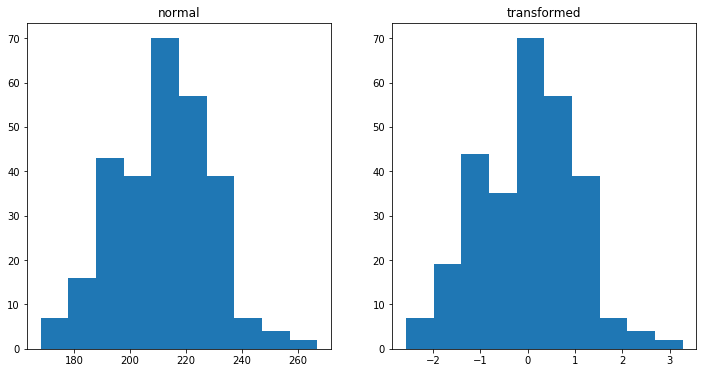

In [23]:
#  Check the Distribution of weight
Wt_pt = power_transform(np.asarray(X_train['Wt']).reshape(-1,1),method='yeo-johnson' )
compareHist(X_train.Wt, Wt_pt)
plt.savefig('./transform_weight.png')

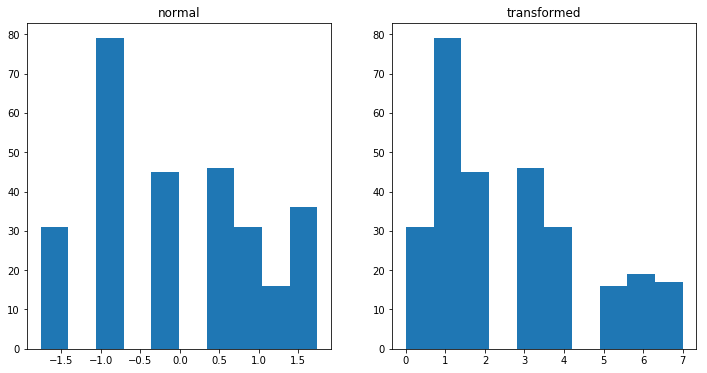

In [24]:
# Check the Draft Round 
draftRnd_pt = power_transform(np.asarray(X_train['draftRnd']).reshape(-1,1),method='yeo-johnson' )
compareHist(draftRnd_pt, X_train.draftRnd)
plt.savefig('./transform_Rnd.png')

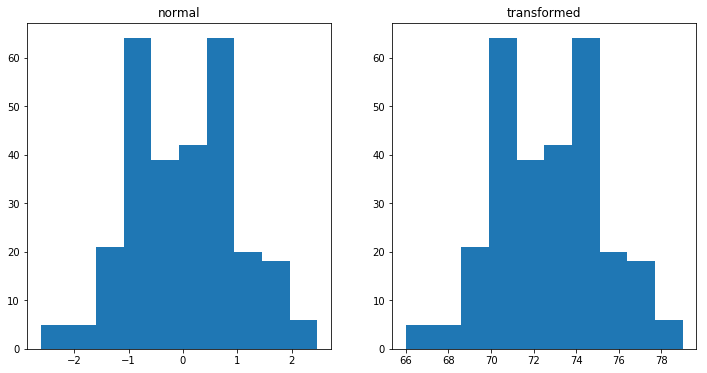

In [25]:
# Check distribution of Height
htinch_pt = power_transform(np.asarray(X_train['ht_inch']).reshape(-1,1),method='box-cox' )
compareHist(htinch_pt, X_train['ht_inch'])

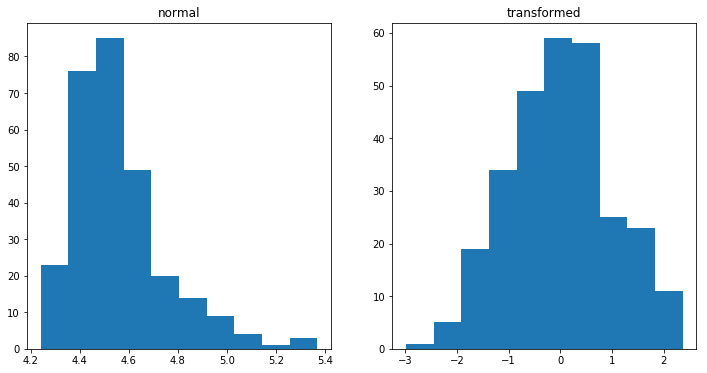

In [26]:
# Check out the distribution of dash
dash_pt = power_transform(np.asarray(X_train['dash']).reshape(-1,1),method='box-cox' )
compareHist(X_train.dash, dash_pt)
plt.savefig('./transform_dash.png')

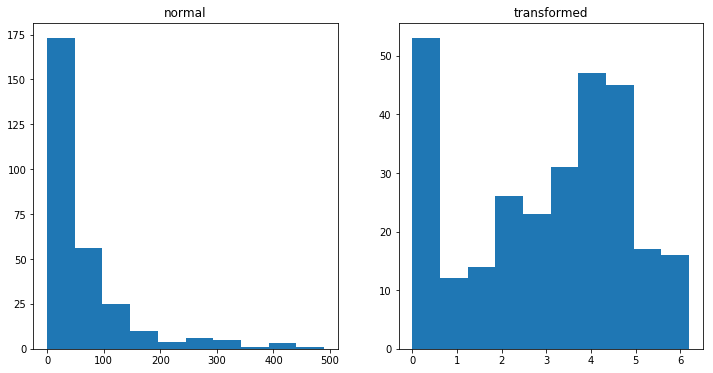

In [27]:
# Checkout the performance of YR1 after doing log transformation
yr1_log = np.log1p(X_train.yr1)
compareHist(X_train.yr1, yr1_log)
plt.savefig('./transform_yr1.png')

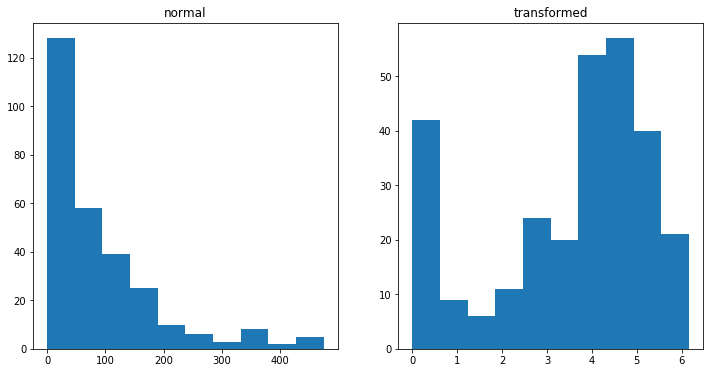

In [28]:
# Checkout the performance of YR2 after doing log transformation
yr2_log = np.log1p(X_train.yr2)
compareHist(X_train.yr2, yr2_log)
plt.savefig('./transform_yr2.png')

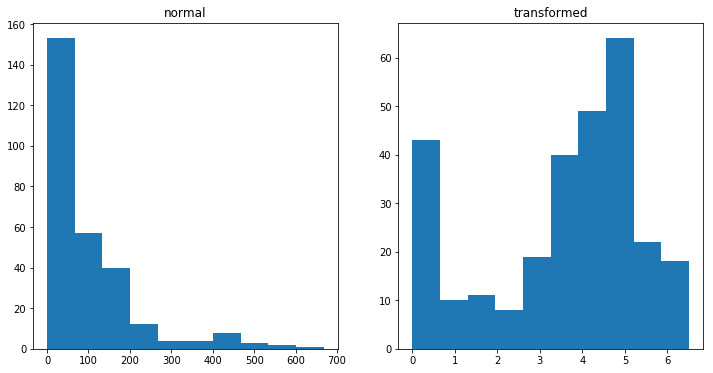

In [29]:
# Checkout the performance of YR3 after doing log transformation
yr3_log = np.log1p(X_train.yr3)
compareHist(X_train.yr3, yr3_log)
plt.savefig('./transform_yr3.png')


<Figure size 432x288 with 0 Axes>

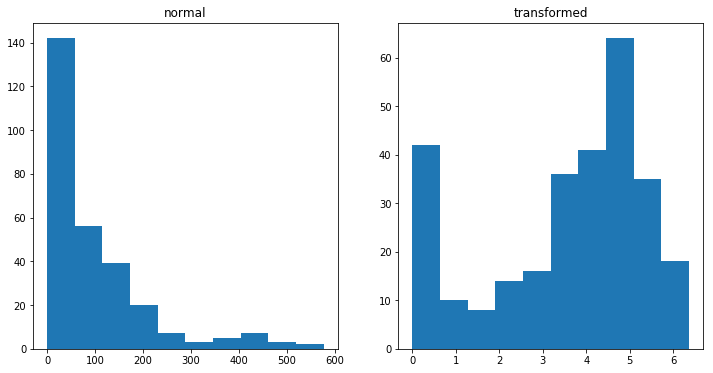

In [30]:
# Checkout the performance of YR4 after doing log transformation
fig = plt.figure()
yr4_log = np.log1p(X_train.yr4)
compareHist(X_train.yr4, yr4_log)
plt.savefig('./transform_yr4.png')

- Looks like applying log1p transformation on yr1,yr2, etc. made their distributions normal-ish. However, there's still huge amnt of zeros
- Some other features need other types of transformations, e.g., box-cox for the 'dash' variable

---

### Making new dataframe with tranformed features

In [31]:
# Make a new copy of dataframe 
df_final = df.copy()

In [33]:
# TRANSFORMATION LIST
df_final['draftRnd_yj'] = power_transform(np.asarray(df_final['draftRnd']).reshape(-1,1), method='yeo-johnson')
df_final['yr1_l1p'] = np.log1p(df.yr1)
df_final['yr2_l1p'] = np.log1p(df.yr2)
df_final['yr3_l1p'] = np.log1p(df.yr3)
df_final['yr4_l1p'] = np.log1p(df.yr4)
df_final['dash_bc'] = power_transform(np.asarray(df_final['dash']).reshape(-1,1), method='box-cox')


In [34]:
# Select columns to use or NOT use

Xorig = df_final[['yr1_l1p','yr2_l1p','yr3_l1p','yr4_l1p','dash_bc','Wt','ht_inch','draftRnd_yj',
                  'pos_RB','pos_WR','draftStat_Yes']]
yorig = df_final['Salary_log1p']
                  
print(Xorig.shape)
Xorig.sample()

(356, 11)


,yr1_l1p,yr2_l1p,yr3_l1p,yr4_l1p,dash_bc,Wt,ht_inch,draftRnd_yj,pos_RB,pos_WR,draftStat_Yes
260,0.470004,3.799974,3.091042,3.459466,-1.890032,204,72,0.386558,0,1,1


### Split up Training and Test Sets

In [35]:
# Hold out 20% of the data for final testing: TRAIN and TEST
X_train, X_test, y_train, y_test = train_test_split(Xorig, yorig, test_size=.2, random_state=10)


In [36]:
print('size of all observations: ', Xorig.shape)
print('size of training set    : ', X_train.shape)
print('size of testing set     : ', X_test.shape)

size of all observations:  (356, 11)
size of training set    :  (284, 11)
size of testing set     :  (72, 11)


### Find the best alphas for regularizations, using LassoCV and RidgeCV

In [37]:
# Feature scale our X's 
scaler= StandardScaler()
scaler.fit(X_train.values) #<< Only fit the X_train

X_train_sc = scaler.transform(X_train.values)

In [38]:
alphavec = 10**np.linspace(-4,4,200)

lasso_model = LassoCV(alphas = alphavec, cv=10,)
lasso_model.fit(X_train_sc, y_train)

ridge_model = RidgeCV(alphas = alphavec, cv=10, )
ridge_model.fit(X_train_sc, y_train)

eln_model = ElasticNetCV(alphas = alphavec, cv=10, )
eln_model.fit(X_train_sc, y_train)

ElasticNetCV(alphas=array([1.00000e-04, 1.09699e-04, ..., 9.11589e+03, 1.00000e+04]),
       copy_X=True, cv=10, eps=0.001, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [39]:
best_alpha_lasso = lasso_model.alpha_
best_alpha_lasso

0.005872786613189483

In [40]:
best_alpha_ridge = ridge_model.alpha_
best_alpha_ridge

38.72038781812557

In [41]:
best_alpha_eln = eln_model.alpha_
best_alpha_eln

0.011226677735108135

### NOW, apply different learning models on the dataset

In [42]:
# Make Dictionary of different models
models = {
        'LR': LinearRegression(),
        'LR-lasso': Lasso(best_alpha_lasso),
        'LR-ridge': Ridge(best_alpha_ridge),
        'Eln' : ElasticNet(best_alpha_eln),
        'RandForest': RandomForestRegressor(),
        'DecisionTree': DecisionTreeRegressor(),
        'Bagging' : BaggingRegressor(),
         }
         

# Parameters
seed = 7
scoring = 'neg_mean_squared_error'

# Evaluation
results =[]
names =[]
summary=[]
residuals = []


for name, model in models.items():
    
    # Setup Kfold and CV
    kfold = KFold(n_splits=10, random_state= seed)
    cv_results = cross_val_score(model, X_train_sc, y_train, cv= kfold, scoring=scoring)
    
    results.append(cv_results)
    names.append(name)
    
    # Setup summary table
    for fold_id, cv in enumerate(cv_results):
        summary.append((name, fold_id,  np.sqrt(-cv)))

    msg = "CV for %s: %f std(%f)" %(name, np.sqrt(-cv_results).mean(), cv_results.std())
    print(msg)
    
df_sum = pd.DataFrame(summary, columns=['names', 'fold_idx', 'rmse'])

CV for LR: 0.610505 std(0.103949)
CV for LR-lasso: 0.609486 std(0.100894)
CV for LR-ridge: 0.610716 std(0.100624)
CV for Eln: 0.609440 std(0.100674)
CV for RandForest: 0.665800 std(0.126262)
CV for DecisionTree: 0.868283 std(0.205544)
CV for Bagging: 0.670853 std(0.113442)


In [43]:
df_sum.sample(5)

,names,fold_idx,rmse
66,Bagging,6,0.673661
23,LR-ridge,3,0.562812
41,RandForest,1,0.760830
42,RandForest,2,0.698847
51,DecisionTree,1,1.102630


In [44]:
# Which one performs best?
df_sum.groupby('names')[['rmse']].mean().sort_values(by='rmse',ascending=True)

,rmse
names,
Eln,0.609440
LR-lasso,0.609486
LR,0.610505
LR-ridge,0.610716
RandForest,0.665800
Bagging,0.670853
DecisionTree,0.868283


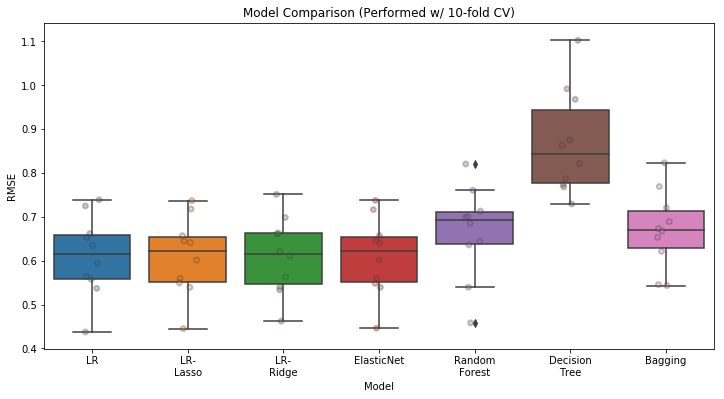

In [45]:
# Plotting the performance of algorithms

fig = plt.figure(figsize=(12,6))
sns.boxplot(x = 'names', y= 'rmse', data=df_sum)
sns.stripplot(x= 'names', y= 'rmse', data=df_sum, jitter=True, edgecolor="gray", alpha = 0.3,linewidth=2)

# plt.hlines(df_R2.groupby('names').mean().loc[['LR-lasso']].accuracy, -1, 8, linestyles='dotted')
plt.title('Model Comparison (Performed w/ 10-fold CV)')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(range(0,7),['LR','LR-\nLasso','LR-\nRidge','ElasticNet','Random\nForest','Decision\nTree',
                      'Bagging'])
# plt.grid(which='major', axis='y',)
# fig.savefig('Compare10fold-2.png', bbox_inches='tight')
# plt.show()
fig.savefig('./Alg_comparison_RMSE.png')

- The performance of linear regression models (w/ & w/o regularizations) are fairly similar
- Linear regressors are still better than tree-based regressors, at least out of the box (w/o Hyperparametric tuning)

---

### Which features are important according to Random Forest?

In [46]:
# Investigate look at features of importance in Random Forest Regressor
RF = RandomForestRegressor()
RF.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [47]:
df_rf = pd.DataFrame(np.c_[list(X_train.columns), list(RF.feature_importances_)], columns =['Features','Importance'])
df_rf['Importance'] = df_rf['Importance'].astype(float)
df_rf

,Features,Importance
0,yr1_l1p,0.101306
1,yr2_l1p,0.149357
2,yr3_l1p,0.297725
3,yr4_l1p,0.163794
4,dash_bc,0.087551
5,Wt,0.081044
6,ht_inch,0.054622
7,draftRnd_yj,0.051513
8,pos_RB,0.007281
9,pos_WR,0.003489


<Figure size 432x288 with 0 Axes>

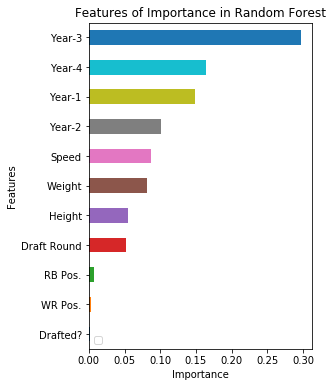

In [48]:
# Plot features of importance
fig=plt.figure()
df_rf.sort_values(by='Importance',ascending=True).plot.barh(x='Features',y='Importance',
                                                            figsize=(4,6))
plt.legend('',loc=3)
plt.title('Features of Importance in Random Forest')
plt.xlabel('Importance')
plt.yticks(range(0,11), ['Drafted?','WR Pos.','RB Pos.','Draft Round','Height','Weight','Speed','Year-2','Year-1','Year-4','Year-3'])
plt.savefig('./RF_featuresImportance.png')

- It seems to make sense, players' Year3 and Year4 performance are the most important factor in the model's salary prediction 

---

### Try investigate R2 among different models

In [49]:
# Make Dictionary of different models
models = {
        'LR': LinearRegression(),
        'LR-lasso': Lasso(best_alpha_lasso),
        'LR-ridge': Ridge(best_alpha_ridge),
        'Eln' : ElasticNet(best_alpha_eln),
        'RandForest': RandomForestRegressor(),
        'DecisionTreeRegressor': DecisionTreeRegressor(),
        'Bagging' : BaggingRegressor(),
#         'DecisionTree': DecisionTreeRegressor()
         }
         
# Parameters
seed = 7
scoring = 'r2'

# Evaluation
results =[]
names =[]
summary=[]
residuals = []


for name, model in models.items():
    
    # Setup Kfold and CV
    kfold = KFold(n_splits=10, random_state= seed)
    cv_results = cross_val_score(model, X_train_sc, y_train, cv= kfold, scoring=scoring)
    
    results.append(cv_results)
    names.append(name)
    
    # Setup summary table
    for fold_id, cv in enumerate(cv_results):
        summary.append((name, fold_id,  cv))

    msg = "CV for %s: %f std(%f)" %(name, cv_results.mean(), cv_results.std())
    print(msg)
    
df_sum = pd.DataFrame(summary, columns=['names', 'fold_idx', 'r2'])

CV for LR: 0.213635 std(0.223624)
CV for LR-lasso: 0.217331 std(0.218472)
CV for LR-ridge: 0.217726 std(0.206845)
CV for Eln: 0.217640 std(0.217672)
CV for RandForest: 0.097246 std(0.220017)
CV for DecisionTreeRegressor: -0.640825 std(0.821258)
CV for Bagging: 0.004406 std(0.379470)


In [50]:
df_sum.groupby('names')[['r2']].mean().sort_values(by='r2',ascending=False)

,r2
names,
LR-ridge,0.217726
Eln,0.217640
LR-lasso,0.217331
LR,0.213635
RandForest,0.097246
Bagging,0.004406
DecisionTreeRegressor,-0.640825


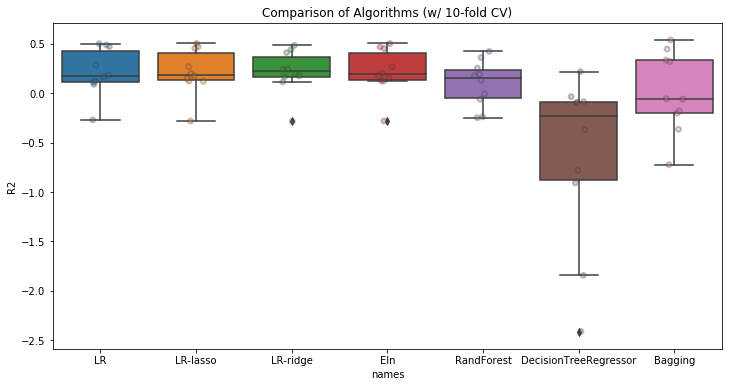

In [51]:
# Comparing the performance of algorithms

fig = plt.figure(figsize=(12,6))
sns.boxplot(x = 'names', y= 'r2', data=df_sum)
sns.stripplot(x= 'names', y= 'r2', data=df_sum, jitter=True, edgecolor="gray", alpha = 0.3,linewidth=2)

# plt.hlines(df_R2.groupby('names').mean().loc[['LR-lasso']].accuracy, -1, 8, linestyles='dotted')
plt.title('Comparison of Algorithms (w/ 10-fold CV)')
plt.ylabel('R2')
# plt.grid(which='major', axis='y',)
# fig.savefig('Compare10fold-2.png', bbox_inches='tight')
plt.show()
fig.savefig('./Alg_comparison_r2.png')

- Consistent with the previous plot, linear regressors have better R2 values than tree-based models 

---

### Selecting the best model: >>>>>> Simple Linear Regression <<<<<<
- Now, use this model to train on the entire dataset, and make predictions on the test set

In [52]:
# Training on the entire training set
simple_lr = LinearRegression()
simple_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [53]:
# Testing on the TEST SET.....!
y_test_pred = simple_lr.predict(X_test)
test_residuals = y_test - y_test_pred

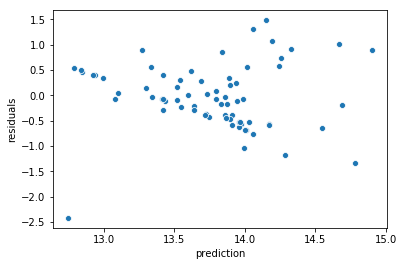

In [54]:
# Plot of residuals
fig = plt.figure()
sns.scatterplot(y_test_pred, test_residuals)
plt.ylabel('residuals')
plt.xlabel('prediction')
fig.savefig('./residuals_model.png')

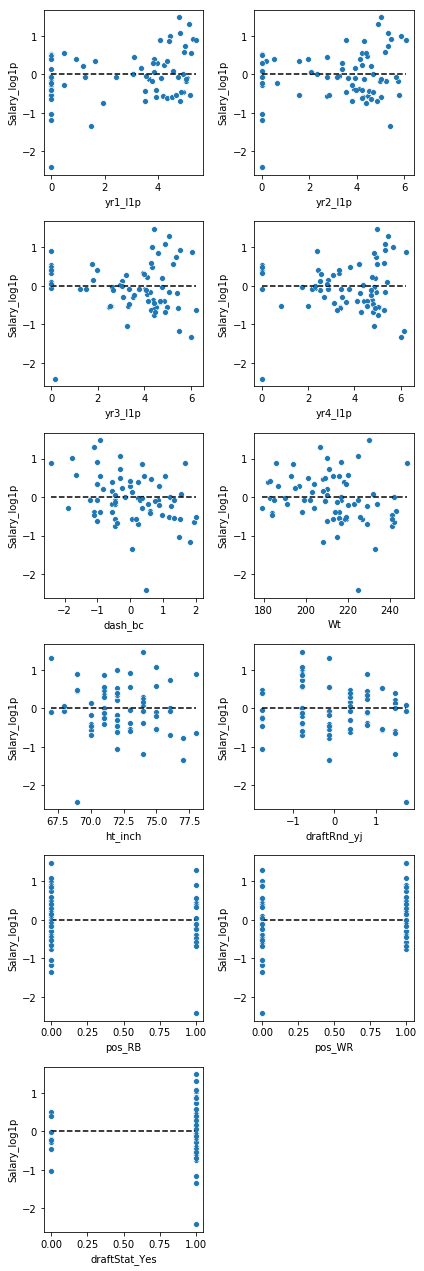

In [55]:
labels = list(X_test.columns) 

# Residuals
fig =plt.figure(figsize=(6,32))

for ind, col in enumerate(range(X_test.shape[1])):    
    plt.subplot(X_test.shape[1],2,ind+1)
    sns.scatterplot(X_test.iloc[:,col], test_residuals)
    plt.plot(X_test.iloc[:,col], test_residuals, 'o',markersize=2)
    
    plt.hlines(0, X_test.iloc[:,col].min(),X_test.iloc[:,col].max(), linestyles='--')
plt.tight_layout()
fig.savefig('./residuals_test_vs_variables.png')

- There are some patterns of heteroskedacity (still)

In [56]:
# Final result 

y_test_pred = simple_lr.predict(X_test)

rmse_final = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_result = r2_score(np.asarray(y_test), np.asarray(y_test_pred))

print('RMSE of Test Set: ', rmse_final)
print('R2   of Test Set: ', r2_result)

RMSE of Test Set:  0.637628975912142
R2   of Test Set:  0.32371696859448773


**RESULT:**
- It's an OK model, considering it's just a simple multivariate linear regression model 
- low R2, but it's a good start! and definitely better than random guessing (R2 =0)

---

### Now convert prediction result into Salaries in USD

In [57]:
# Converting yvalues back to $$
df_ytest = pd.DataFrame(np.exp(y_test)-1)
df_ytest.columns = ['Salary']
df_ytest.head()

,Salary
212,900715.00
97,893466.75
114,600600.00
6,6435000.00
126,628650.00


In [58]:
# Converting ypred back to $$

df_ypred = pd.DataFrame(np.exp(y_test_pred)-1, columns =['Salary'])
df_ypred.head()

,Salary
0,9.787169e+05
1,1.059186e+06
2,3.784029e+05
3,2.351416e+06
4,9.127007e+05


In [59]:
# Calculate RMSE, in terms of salaries world
rmse = np.sqrt(mean_squared_error(np.asarray(df_ytest), np.asarray(df_ypred)))

print('How off is my prediction? ${}'.format(round(rmse)))


How off is my prediction? $1197485.0


In [60]:
# Summary of y values 
df_y_summary = pd.concat([df_ytest.reset_index(),df_ypred.reset_index()], axis=1)
df_y_summary = df_y_summary.drop(columns = ['index'])

### Check out the overall performance of the model, with respect to the test set 

In [72]:
df_y_summary.columns = ['True','Predicted']

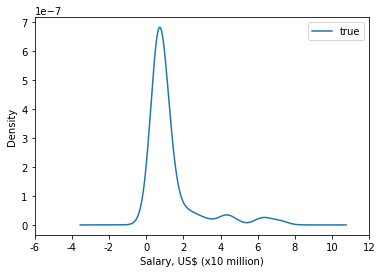

In [79]:
# plt.figure(figsize=(12,8))
fig = plt.figure()
df_y_summary.iloc[:,0].plot.kde(bw_method=0.3)
plt.xlim((-0.5e7, 1.2e7))
plt.xlabel('Salary, US$ (x10 million)')
plt.legend(['true','prediction'])
# plt.ylim(-5e-8, 1.1e-6)
plt.xticks([-6000000., -4000000., -2000000.,        0.,  2000000.,  4000000.,
         6000000.,  8000000., 10000000., 12000000.], 
           [str(x) for x in range(-6,14,2 )])
fig.savefig('./ytest_distribution.png')

<Figure size 432x288 with 0 Axes>

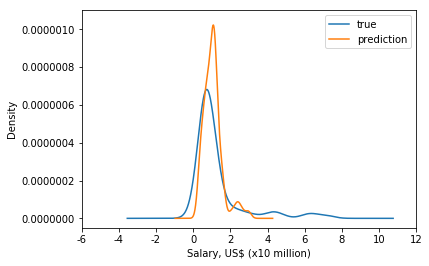

In [75]:
# plt.figure(figsize=(12,8))

fig = plt.figure()
df_y_summary.plot.kde(bw_method=0.3)
plt.xlim((-0.5e7, 1.2e7))
plt.xlabel('Salary, US$ (x10 million)')
plt.legend(['true','prediction'])
plt.ylim(-5e-8, 1.1e-6)
plt.xticks([-6000000., -4000000., -2000000.,        0.,  2000000.,  4000000.,
         6000000.,  8000000., 10000000., 12000000.], 
           [str(x) for x in range(-6,14,2 )]);
plt.savefig('./ytest_ypred_density.png')


([<matplotlib.axis.XTick at 0x1a227c3cc0>,
 <a list of 10 Text xticklabel objects>)

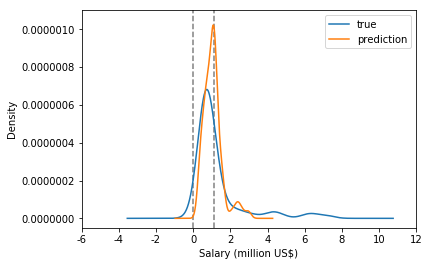

In [78]:
# plt.figure(figsize=(12,8))
df_y_summary.plot.kde(bw_method=0.3)
plt.xlim((-0.5e7, 1.2e7))
plt.xlabel('Salary (million US$)')
plt.legend(['true','prediction'])
plt.ylim(-5e-8, 1.1e-6)
# fig.savefig('./ytest_ypred_density.png')
plt.vlines(0,-5e-8, 1.1e-6,colors='gray',linestyles='dashed')
plt.vlines(1.1e6, -5e-8, 1.1e-6, colors='gray',linestyles='dashed')
plt.xticks([-6000000., -4000000., -2000000.,        0.,  2000000.,  4000000.,
         6000000.,  8000000., 10000000., 12000000.], 
           [str(x) for x in range(-6,14,2 )])

Notes:
- Lineshapes are fairly similar, with some discrepancies
- The model is overly confident in predicting lower-range Salaries, and misses the mark on the higher-income range 
- Error (RMSE) is ~1.1 million

---